In [1]:
# !pip install lalsuite
# !pip install nestle

In [2]:
#!/usr/bin/env python
"""
Tutorial to demonstrate running parameter estimation on a binary neutron star
system taking into account tidal deformabilities.

This example estimates the masses using a uniform prior in both component masses
and also estimates the tidal deformabilities using a uniform prior in both
tidal deformabilities
"""
#Hello!
# ! git clone -b BinaryLove https://git.ligo.org/cjhaster/bilby.git
import sys
sys.path.insert(0,'/home/marc.penuliar/bilby') 
import bilby
import numpy as np

No version information file '.version' found


In [3]:
# Specify the output directory and the name of the simulation.
outdir = "outdir"
label = "bns_example"
bilby.core.utils.setup_logger(outdir=outdir, label=label)

In [4]:
# Set up a random seed for result reproducibility.  This is optional!
np.random.seed(88170235)

In [5]:
# We are going to inject a binary neutron star waveform.  We first establish a
# dictionary of parameters that includes all of the different waveform
# parameters, including masses of the two black holes (mass_1, mass_2),
# aligned spins of both black holes (chi_1, chi_2), etc.
injection_parameters = dict(
    mass_1=1.5,
    mass_2=1.3,
    chi_1=0.02,
    chi_2=0.02,
    luminosity_distance=50.0,
    theta_jn=0.4,
    psi=2.659,
    phase=1.3,
    geocent_time=1126259642.413,
    ra=1.375,
    dec=-1.2108,
    lambda_1=400,
    lambda_2=450,
)


In [6]:

# Set the duration and sampling frequency of the data segment that we're going
# to inject the signal into. For the
# TaylorF2 waveform, we cut the signal close to the isco frequency
duration = 32
sampling_frequency = 2048 #4096 changed for later. we need faster test runs
start_time = injection_parameters["geocent_time"] + 2 - duration



In [7]:
# Fixed arguments passed into the source model. The analysis starts at 40 Hz.
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2_NRTidal",
    reference_frequency=50.0,
    minimum_frequency=40.0,
)


In [8]:
# Create the waveform_generator using a LAL Binary Neutron Star source function
waveform_generator = bilby.gw.WaveformGenerator(
    duration=duration,
    sampling_frequency=sampling_frequency,
    frequency_domain_source_model=bilby.gw.source.lal_binary_neutron_star,
    parameter_conversion=bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters,
    waveform_arguments=waveform_arguments,
)


11:26 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_neutron_star
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_neutron_star_parameters


In [9]:
# Set up interferometers.  In this case we'll use three interferometers
# (LIGO-Hanford (H1), LIGO-Livingston (L1), and Virgo (V1)).
# These default to their design sensitivity and start at 40 Hz.
interferometers = bilby.gw.detector.InterferometerList(["H1", "L1", "V1"])
for interferometer in interferometers:
    interferometer.minimum_frequency = 40
interferometers.set_strain_data_from_power_spectral_densities(
    sampling_frequency=sampling_frequency, duration=duration, start_time=start_time
)
interferometers.inject_signal(
    parameters=injection_parameters, waveform_generator=waveform_generator
)


11:26 bilby INFO    : Injected signal in H1:
11:26 bilby INFO    :   optimal SNR = 34.44
11:26 bilby INFO    :   matched filter SNR = 35.22-0.58j
11:26 bilby INFO    :   mass_1 = 1.5
11:26 bilby INFO    :   mass_2 = 1.3
11:26 bilby INFO    :   chi_1 = 0.02
11:26 bilby INFO    :   chi_2 = 0.02
11:26 bilby INFO    :   luminosity_distance = 50.0
11:26 bilby INFO    :   theta_jn = 0.4
11:26 bilby INFO    :   psi = 2.659
11:26 bilby INFO    :   phase = 1.3
11:26 bilby INFO    :   geocent_time = 1126259642.413
11:26 bilby INFO    :   ra = 1.375
11:26 bilby INFO    :   dec = -1.2108
11:26 bilby INFO    :   lambda_1 = 400
11:26 bilby INFO    :   lambda_2 = 450
11:26 bilby INFO    : Injected signal in L1:
11:26 bilby INFO    :   optimal SNR = 27.88
11:26 bilby INFO    :   matched filter SNR = 28.28+0.76j
11:26 bilby INFO    :   mass_1 = 1.5
11:26 bilby INFO    :   mass_2 = 1.3
11:26 bilby INFO    :   chi_1 = 0.02
11:26 bilby INFO    :   chi_2 = 0.02
11:26 bilby INFO    :   luminosity_distance =

[{'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.02066493e-25+1.53786385e-25j, -4.02109206e-25+1.53625167e-25j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.53267924e-25+4.00711004e-25j, 1.53107249e-25+4.00753572e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': array([ 0.00000000e+00-0.00000000e+00j,  0.00000000e+00-0.00000000e+00j,
          0.00000000e+00-0.00000000e+00j, ...,
         -4.02066493e-25+1.53786385e-25j, -4.02109206e-25+1.53625167e-25j,
          0.00000000e+00-0.00000000e+00j]),
  'cross': array([0.00000000e+00+0.00000000e+00j, 0.00000000e+00+0.00000000e+00j,
         0.00000000e+00+0.00000000e+00j, ...,
         1.53267924e-25+4.00711004e-25j, 1.53107249e-25+4.00753572e-25j,
         0.00000000e+00+0.00000000e+00j])},
 {'plus': ar

In [10]:
# Load the default prior for binary neutron stars.
# We're going to sample in chirp_mass, symmetric_mass_ratio, lambda_tilde, and
# delta_lambda rather than mass_1, mass_2, lambda_1, and lambda_2.
# BNS have aligned spins by default, if you want to allow precessing spins
# pass aligned_spin=False to the BNSPriorDict
priors = bilby.gw.prior.BNSPriorDict()
for key in [
    "psi",
    "geocent_time",
    "ra",
    "dec",
    "chi_1",
    "chi_2",
    "theta_jn",
    "luminosity_distance",
    "phase",
]:
    priors[key] = injection_parameters[key]
del priors["lambda_1"], priors["lambda_2"] #priors["mass_ratio"],
priors["chirp_mass"] = bilby.core.prior.Gaussian(
    1.215, 0.1, name="chirp_mass", unit="$M_{\\odot}$"
)
# priors["symmetric_mass_ratio"] = bilby.core.prior.Uniform(
#     0.1, 0.25, name="symmetric_mass_ratio"
# )

##
 # bilby.core.prior.conditional.ConditionalUniform
##


#Using this prior will create lambda1 and lambda2. Outputs are funky
priors["lambda_symmetric"] = bilby.core.prior.Uniform(0, 5000, name="lambda_symmetric") 

# priors["lambda_antisymmetric"] = bilby.core.prior.Uniform(-5000, 5000, name="lambda_antisymmetric")
 
##
 # bilby.core.prior.conditional.ConditionalUniform
##

# priors["binary_love_uniform"] = bilby.core.prior.Uniform(0.4999, 0.5001, name="binary_love_uniform")
priors["binary_love_uniform"] = bilby.core.prior.Uniform(0, 1, name="binary_love_uniform")


priors["lambda_1"] = bilby.core.prior.Constraint(name='lambda_1', minimum=0,maximum=10000)
priors["lambda_2"] = bilby.core.prior.Constraint(name='lambda_2', minimum=0,maximum=10000)


#The next step is to make a larger range for binary love? 

11:26 bilby INFO    : No prior given, using default BNS priors in /home/marc.penuliar/bilby/bilby/gw/prior_files/aligned_spins_bns_tides_on.prior.


In [11]:
# Initialise the likelihood by passing in the interferometer data (IFOs)
# and the waveform generator
likelihood = bilby.gw.GravitationalWaveTransient(
    interferometers=interferometers,
    waveform_generator=waveform_generator,
)



11:26 bilby INFO    : Running for label 'bns_example', output will be saved to 'outdir'
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11:26 bilby INFO    : Performing redundancy check using BBHPriorDict(self).test_redundancy
11

No version information file '.version' found
it=  2044 logz=1452.474477900000052504760255204420248704468581108159154915854115511802457988908195786371375080447864043704443832883878176942523235360430575644792184786706982848387200926575803737830233794788090059368953234970799945081119038967640880074652742780142494579258788820056842838115669472196386865459400540160.000000


12:56 bilby INFO    : Sampling time: 1:29:41.000198
12:57 bilby INFO    : Generating sky frame parameters.


  0%|          | 0/2145 [00:00<?, ?it/s]

12:57 bilby INFO    : Computing SNRs for every sample.


  0%|          | 0/2145 [00:00<?, ?it/s]

13:03 bilby INFO    : Summary of results:
nsamples: 2145
ln_noise_evidence: -95838.299
ln_evidence: -94385.452 +/-  0.426
ln_bayes_factor: 1452.847 +/-  0.426



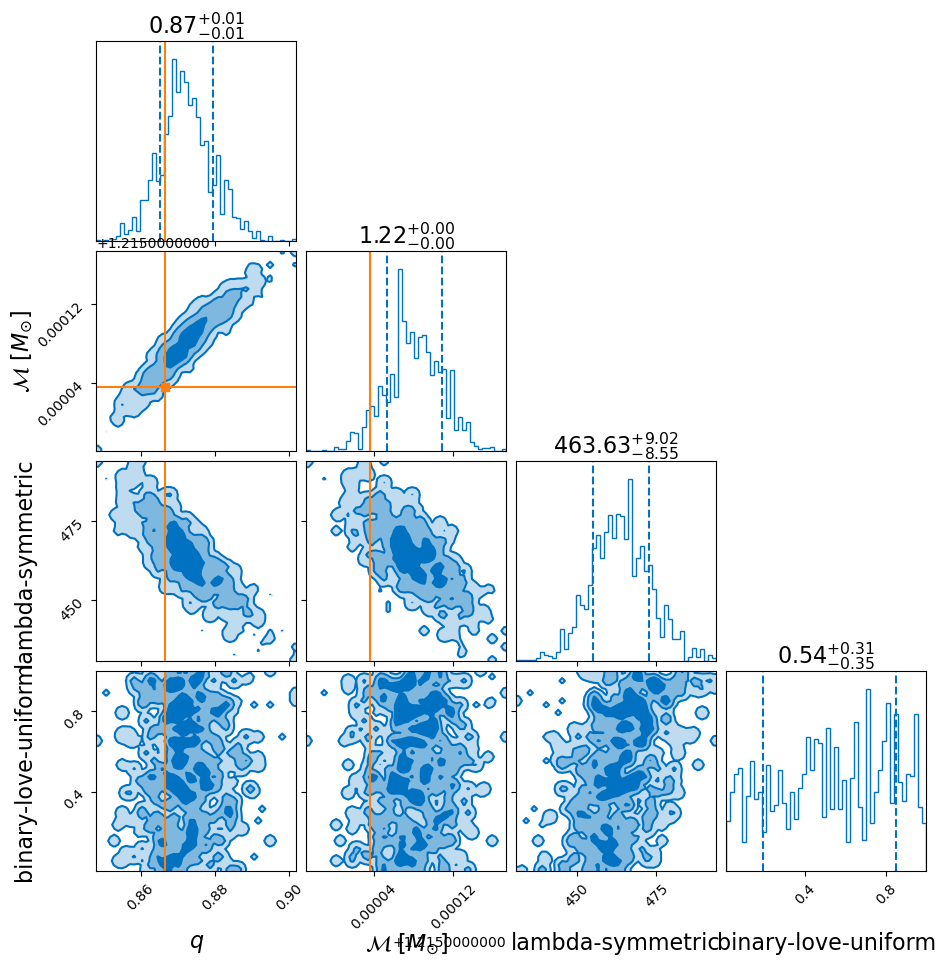

In [12]:

# Run sampler.  In this case we're going to use the `nestle` sampler
result = bilby.run_sampler(
    likelihood=likelihood,
    priors=priors,
    sampler="nestle",
    npoints=100,
    injection_parameters=injection_parameters,
    outdir=outdir,
    label=label,
    conversion_function=bilby.gw.conversion.generate_all_bns_parameters,
)

result.plot_corner()


Text(0.5, 0.98, 'Bilby_Example_Code')

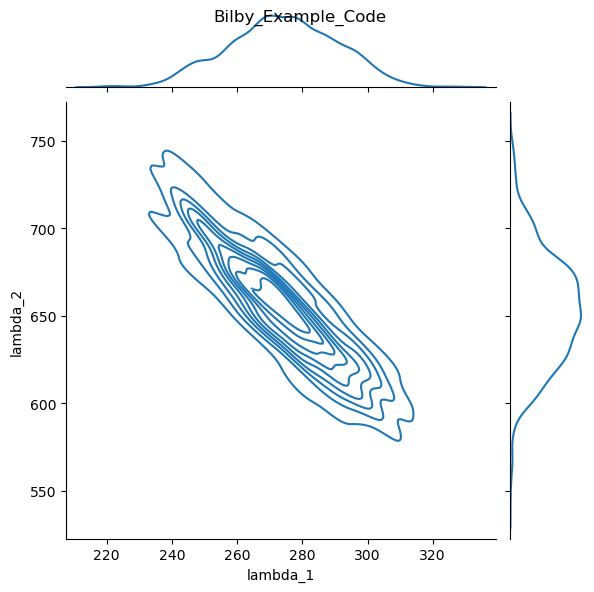

In [13]:
import seaborn as sns 
sns.jointplot( x=result.posterior['lambda_1'], y=result.posterior['lambda_2'],kind = 'kde').fig.suptitle("Bilby_Example_Code")
# sns.title.set(title='hello')